In [1]:
spark

In [2]:
import json
import pandas as pd
import numpy as np


In [89]:
engagement = pd.read_csv('takehome_user_engagement.csv')
users = pd.read_csv('takehome_users.csv',encoding='latin-1')

In [8]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


# Find  "adopted users" and create an "adopted" field in the users table 

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven­day period, identify which factors predict future user adoption.


In [75]:
# find users who logged into the product at least three separate days
#engagement['day'] = pd.to_datetime(engagement['time_stamp'], format='%Y-%m-%d').dt.date
#engagement = engagement.drop_duplicates(subset =['user_id','day'],keep='first') # keep one row per user per day
##total_visits = engagement.groupby('user_id').count()[['visited']]
#over_three = total_visits[total_visits.visited >= 3]

In [90]:
# convert time_stamp to datetime day timestamp and drop duplicates
#engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'], format='%Y-%m-%d').dt.floor('d').astype(np.int64)
engagement['day'] = pd.to_datetime(engagement['time_stamp'], format='%Y-%m-%d').dt.date
df = engagement.sort_values(['user_id', 'time_stamp']).drop_duplicates()
df.head()

,time_stamp,user_id,visited,day
0,2014-04-22 03:53:30,1,1,2014-04-22
1,2013-11-15 03:45:04,2,1,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-12-25


In [100]:
# lag the rows to get the users' previous two logins
df['prev_login'] = df.groupby(['user_id']).day.shift(1)
df['prev_prev_login'] = df.groupby(['user_id']).day.shift(2)
df.head(10)

,time_stamp,user_id,visited,day,prev_login,prev_prev_login
0,2014-04-22 03:53:30,1,1,2014-04-22,NaN,NaN
1,2013-11-15 03:45:04,2,1,2013-11-15,NaN,NaN
2,2013-11-29 03:45:04,2,1,2013-11-29,2013-11-15,NaN
3,2013-12-09 03:45:04,2,1,2013-12-09,2013-11-29,2013-11-15
4,2013-12-25 03:45:04,2,1,2013-12-25,2013-12-09,2013-11-29
5,2013-12-31 03:45:04,2,1,2013-12-31,2013-12-25,2013-12-09
6,2014-01-08 03:45:04,2,1,2014-01-08,2013-12-31,2013-12-25
7,2014-02-03 03:45:04,2,1,2014-02-03,2014-01-08,2013-12-31
8,2014-02-08 03:45:04,2,1,2014-02-08,2014-02-03,2014-01-08
9,2014-02-09 03:45:04,2,1,2014-02-09,2014-02-08,2014-02-03


In [117]:
# find time between login
df['time_between_login'] = df.day - df.prev_prev_login
df['time_between_login'] = df.time_between_login / np.timedelta64(1,'D')
df.head()

,time_stamp,user_id,visited,day,prev_login,prev_prev_login,time_between_login
0,2014-04-22 03:53:30,1,1,2014-04-22,NaN,NaN,NaN
1,2013-11-15 03:45:04,2,1,2013-11-15,NaN,NaN,NaN
2,2013-11-29 03:45:04,2,1,2013-11-29,2013-11-15,NaN,NaN
3,2013-12-09 03:45:04,2,1,2013-12-09,2013-11-29,2013-11-15,24.0
4,2013-12-25 03:45:04,2,1,2013-12-25,2013-12-09,2013-11-29,26.0


In [131]:
# find active user_ids
active = df[df['time_between_login'] <= 7]
active_ids = active['user_id'].drop_duplicates()
active_df = pd.DataFrame(active_ids)
active_df.head()

,user_id
9,2
24,10
312,20
331,33
353,42


In [245]:
# join on users table to get new column (boolean) whether users adopted or not
clean_df = users.merge(active_df, left_on='object_id', right_on='user_id', how='left')
clean_df['adopted'] = np.where(pd.isnull(clean_df.user_id)==False,1,0)
clean_df['invited_by_user_id'] = np.where(pd.isnull(clean_df.invited_by_user_id)==True,0,clean_df.invited_by_user_id)

# create email company column, remove junk emails ( < 2 users w/ email company)
clean_df['email_company'] = clean_df["email"].str.split("@").str[1]
#clean_df.email_company.value_counts()
clean_df['email_company'] = np.where(
    clean_df.email_company.isin(["gmail.com","yahoo.com","jourrapide.com","cuvox.de","gustr.com","hotmail.com"]) == True,
    clean_df.email_company, "unknown")
clean_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,adopted,email_company
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,NaN,0,yahoo.com
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2.0,1,gustr.com
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,NaN,0,gustr.com
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,NaN,0,yahoo.com
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,NaN,0,yahoo.com


In [247]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 13 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null float64
user_id                       1656 non-null float64
adopted                       12000 non-null int64
email_company                 12000 non-null object
dtypes: float64(3), int64(5), object(5)
memory usage: 1.3+ MB


# Load into SparkSQL

In [248]:
from pyspark.sql import SparkSession
from pyspark.sql.window import Window 
from pyspark.sql.functions import row_number,lit

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

sc = spark.sparkContext

df = spark.createDataFrame(clean_df)

In [249]:
df.limit(10).toPandas()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,adopted,email_company
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,NaN,0,yahoo.com
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2.0,1,gustr.com
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,NaN,0,gustr.com
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,NaN,0,yahoo.com
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,NaN,0,yahoo.com
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,NaN,0,yahoo.com
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,0.0,NaN,0,jourrapide.com
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,0.0,NaN,0,yahoo.com
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,0.0,NaN,0,hotmail.com
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,10.0,1,gustr.com


# Vectorize categorical and numerical features

In [250]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

cols = df.columns 

categoricalColumns = ["creation_source","email_company"]
stages = [] # stages in our Pipeline

for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

In [251]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="adopted", outputCol="label")
stages += [label_stringIdx]

In [252]:
# Transform all features into a vector using VectorAssembler
numericCols = ["opted_in_to_mailing_list","enabled_for_marketing_drip","org_id","invited_by_user_id"]

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [253]:
# Create a Pipeline.
pipeline = Pipeline(stages=stages)

# Run the feature transformations.
#  - fit() computes feature statistics as needed.
#  - transform() actually transforms the features.
pipelineModel = pipeline.fit(df)
dataset = pipelineModel.transform(df)

# Keep relevant columns
selectedcols = ["label", "features"] + cols
dataset = dataset.select(selectedcols)
dataset.limit(10).toPandas()

,label,features,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,adopted,email_company
0,0.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,NaN,0,yahoo.com
1,1.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2.0,1,gustr.com
2,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,NaN,0,gustr.com
3,0.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,NaN,0,yahoo.com
4,0.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,NaN,0,yahoo.com
5,0.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,NaN,0,yahoo.com
6,0.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,0.0,NaN,0,jourrapide.com
7,0.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,0.0,NaN,0,yahoo.com
8,0.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,0.0,NaN,0,hotmail.com
9,1.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,10.0,1,gustr.com


# Build Random Forest classifier

In [254]:
# first define accuracy metrics for model
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

def print_performance_metrics(predictions):
    # Evaluate model
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
    auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
    aupr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
    print("auc = {}".format(auc))
    print("aupr = {}".format(aupr))

    # get rdd of predictions and labels for mllib eval metrics
    predictionAndLabels = predictions.select("prediction","label").rdd

    # Instantiate metrics objects
    binary_metrics = BinaryClassificationMetrics(predictionAndLabels)
    multi_metrics = MulticlassMetrics(predictionAndLabels)

    # Area under precision-recall curve
    print("Area under PR = {}".format(binary_metrics.areaUnderPR))
    # Area under ROC curve
    print("Area under ROC = {}".format(binary_metrics.areaUnderROC))
    # Accuracy
    print("Accuracy = {}".format(multi_metrics.accuracy))
    # Confusion Matrix
    print(multi_metrics.confusionMatrix())

    ### Question 5.1 Answer ###

    # F1
    print("F1 = {}".format(multi_metrics.fMeasure()))
    # Precision
    print("Precision = {}".format(multi_metrics.precision()))
    # Recall
    print("Recall = {}".format(multi_metrics.recall()))
    # FPR
    print("FPR = {}".format(multi_metrics.falsePositiveRate(1.0)))
    # TPR
    print("TPR = {}".format(multi_metrics.truePositiveRate(1.0)))

In [255]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from itertools import chain

# split into train and test data
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=100)
print('Rows in training data:',trainingData.count())
print('Rows in test data    :',testData.count())

# Create initial Random Forest model
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

Rows in training data: 8463
Rows in test data    : 3537


In [256]:
# Create ParamGrid for Cross Validation
rfParamGrid = (ParamGridBuilder()
               .addGrid(rf.maxDepth, [3,5,7])
               .addGrid(rf.maxBins, [20, 40, 60])
               .addGrid(rf.numTrees, [10,20,30])
               .build())

print('Total Models (with all hyperparameter combinations):', len(rfParamGrid))

Total Models (with all hyperparameter combinations): 27


In [257]:
# set up an evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Create CrossValidator
rfCv = CrossValidator(estimator=rf, estimatorParamMaps=rfParamGrid, evaluator=evaluator, numFolds=3)

# Run cross validations
rfCvModel = rfCv.fit(trainingData)

In [258]:
# look at best params from the CV
print(rfCvModel.bestModel._java_obj.getMaxDepth())
print(rfCvModel.bestModel._java_obj.getMaxBins())
print(rfCvModel.bestModel._java_obj.getNumTrees())

rfCvModel.bestModel._java_obj.extractParamMap()

7
20
20


JavaObject id=o65691

In [259]:
rfCvPredictions = rfCvModel.transform(testData)

rfCvPredictions.limit(10).toPandas()

,label,features,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,adopted,email_company,rawPrediction,probability,prediction
0,0.0,"(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",3020,2014-05-18 12:45:01,Traugott Benjamin,BenjaminTraugott@gmail.com,ORG_INVITE,1.400590e+09,1,1,54,6723.0,NaN,0,gmail.com,"[17.0905470651, 2.90945293492]","[0.854527353254, 0.145472646746]",0.0
1,0.0,"(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1795,2013-04-17 06:44:10,O'Brien Lilly,LillyOBrien@gmail.com,ORG_INVITE,1.366181e+09,1,1,85,8426.0,NaN,0,gmail.com,"[16.9209066777, 3.07909332226]","[0.846045333887, 0.153954666113]",0.0
2,0.0,"(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1763,2014-01-20 01:24:11,McGovern Luke,LukeMcGovern@gmail.com,ORG_INVITE,1.390181e+09,1,1,86,1037.0,NaN,0,gmail.com,"[17.0886876442, 2.91131235579]","[0.854434382211, 0.145565617789]",0.0
3,0.0,"(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",2330,2013-10-23 01:22:07,Propst Jens,JensPropst@gmail.com,ORG_INVITE,NaN,1,1,93,2723.0,NaN,0,gmail.com,"[17.0886876442, 2.91131235579]","[0.854434382211, 0.145565617789]",0.0
4,0.0,"(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",170,2014-01-06 09:37:49,Bryson Keith,KeithKBryson@gmail.com,ORG_INVITE,NaN,1,1,134,11484.0,NaN,0,gmail.com,"[17.04860115, 2.95139885003]","[0.852430057499, 0.147569942501]",0.0
5,0.0,"(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1332,2013-12-14 05:09:47,Sewell Tayla,TaylaSewell@gmail.com,ORG_INVITE,1.387084e+09,1,1,150,3784.0,NaN,0,gmail.com,"[17.0606483416, 2.93935165836]","[0.853032417082, 0.146967582918]",0.0
6,0.0,"(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1595,2012-11-13 10:17:05,Lowe Kenneth,KennethNLowe@gmail.com,ORG_INVITE,1.352802e+09,1,1,161,11195.0,NaN,0,gmail.com,"[17.04860115, 2.95139885003]","[0.852430057499, 0.147569942501]",0.0
7,0.0,"(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",402,2013-07-13 03:40:42,Holden Summer,SummerHolden@gmail.com,ORG_INVITE,1.373773e+09,1,1,185,9691.0,NaN,0,gmail.com,"[17.04860115, 2.95139885003]","[0.852430057499, 0.147569942501]",0.0
8,0.0,"(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1494,2013-02-15 21:27:07,Kaiser Gabriele,GabrieleKaiser@gmail.com,ORG_INVITE,1.360964e+09,1,1,260,8817.0,NaN,0,gmail.com,"[16.935259881, 3.06474011898]","[0.846762994051, 0.153237005949]",0.0
9,0.0,"(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1170,2014-04-27 16:48:34,Sankt Janina,JaninaSankt@gmail.com,ORG_INVITE,1.398617e+09,1,1,285,623.0,NaN,0,gmail.com,"[16.8399560471, 3.16004395287]","[0.841997802356, 0.158002197644]",0.0


In [260]:
print_performance_metrics(rfCvPredictions)

auc = 0.5923341887865374
aupr = 0.1648980354978088
Area under PR = 0.13401187446988974
Area under ROC = 0.5
Accuracy = 0.8659881255301103
DenseMatrix([[ 3063.,     0.],
             [  474.,     0.]])
F1 = 0.8659881255301103
Precision = 0.8659881255301103
Recall = 0.8659881255301103
FPR = 0.0
TPR = 0.0


In [261]:
# extract metadata
attrs = sorted(
    (attr["idx"], attr["name"]) for attr in (chain(*trainingData
        .schema["features"]
        .metadata["ml_attr"]["attrs"].values())))


# combine with feature importance
rf_feature_coef = [(name, rfCvModel.bestModel.featureImportances[idx])
 for idx, name in attrs
 if rfCvModel.bestModel.featureImportances[idx]]

In [279]:
# convert to dataframe
rf_feature_tbl = pd.DataFrame(list(rf_feature_coef),columns=['feature','coefficient'])

# print out top features with largest coefficients
rf_feature_tbl.sort_values('coefficient', ascending=False).head(20)

,feature,coefficient
12,org_id,0.416735
13,invited_by_user_id,0.139128
2,creation_sourceclassVec_PERSONAL_PROJECTS,0.135655
1,creation_sourceclassVec_GUEST_INVITE,0.062314
5,email_companyclassVec_yahoo.com,0.053087
10,opted_in_to_mailing_list,0.052268
11,enabled_for_marketing_drip,0.029672
4,email_companyclassVec_gmail.com,0.023366
7,email_companyclassVec_cuvox.de,0.021607
9,email_companyclassVec_gustr.com,0.021061


In [280]:
sorted_features = rf_feature_tbl.sort_values('coefficient', ascending=False)

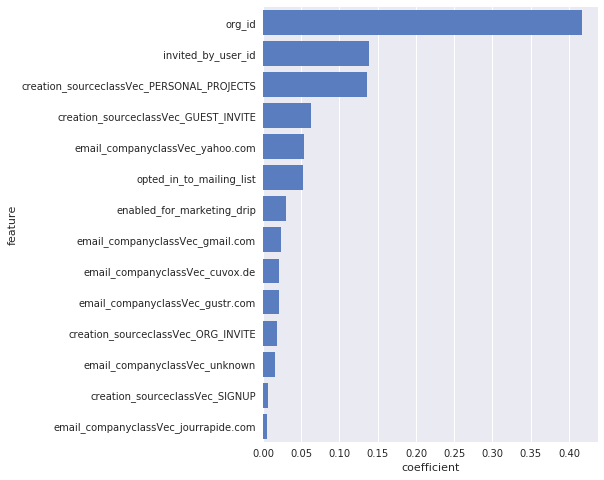

In [282]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(6, 8))

sns.barplot(x="coefficient", y="feature", data=sorted_features,
            label="Feature importance in predicting adoption", color="b")

sns.set_color_codes("muted")

plt.show()

### The most important features in predicting adoption are:
 * **org_id** - the organization the user belongs to (the greatest predictor by far)
 * **invited_by_user_id** - which user invited them to join 
 * **creation_source.PERSONAL_PROJECTS** - users invited to join another user's personal workspace
 * **creation_source.GUEST_INVITE** - users invited to an organization as a guest 
 * **email_company** - yahoo.com email addresses